To Do:
* Confusion matrix diagram for best model
* Add explanation for why to use SMOTE, options of over and/or under sampling.
* Add in other models to this notebook

# Library Imports

In [1]:
# Dataframes
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Preparation
    # Train:Test
from sklearn.model_selection import train_test_split

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# Model metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# SMOTE
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier 
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier 

import itertools

# # KNN
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import metrics
# from scipy.spatial import distance
# # Logistic Regression

# from sklearn.linear_model import LogisticRegression
#     # Statsmodel
# import statsmodels.api as sm
# from patsy import dmatrices

# # Random Forest
# from sklearn.tree import DecisionTreeClassifier  # Decision Tree
# from sklearn.ensemble import BaggingClassifier, RandomForestClassifier  #Bagging & Random Forest
# from sklearn import tree
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
#     # Visuals for Random Forest
# from sklearn.externals.six import StringIO
# from IPython.display import Image
# from sklearn.tree import export_graphviz

# # SVC
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix , accuracy_score

# Import Cleaned Data 

In [2]:
df = pd.read_csv('../data/processed/cleaned_dataframe.gz', compression='gzip')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
df_scaled = pd.read_csv('../data/processed/cleaned_dataframe_scaled.gz', compression='gzip')
df_scaled.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Amount,Scaled_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.774718,-0.995290
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.268530,-0.995290
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.959811,-0.995279


# Train:Test Split

## Without Scaling

In [4]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=1)

print("No. of samples in each training set:\t{}".format(X_train.shape[0]))
print("No. of samples in each test set:\t{}".format(X_test.shape[0]))

No. of samples in each training set:	198608
No. of samples in each test set:	85118


We choose to stratify as we want to keep the distribution of classes the same in the training set as the test set. 

## With Scaling

In [5]:
X_sc = df_scaled.drop(['Class'], axis=1)
y_sc = df_scaled['Class']

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc,
                                                                test_size=0.3,
                                                                stratify=y_sc,
                                                                random_state=1)


print("No. of samples in each training set:\t{}".format(X_train.shape[0]))
print("No. of samples in each test set:\t{}".format(X_test.shape[0]))

No. of samples in each training set:	198608
No. of samples in each test set:	85118


# Resampling

* We can resample the dataset in order to improve the effectiveness of many machine learning models
* Resampling involves drawing repeated samples from the original dataset to create a new dataset which either reduces the ratio of the majority class (undersampling) or increases the ratio of the minority class (oversampling).  A combination of the two can also be used
* Often undersampling will produce better results, but with such imbalanced data we will choose to oversample for this dataset, as it means we are not losing any data from the original dataset.
* Synthetic Minority Oversampling TEchnique (SMOTE) will be used to produce a more class-balanced dataset.

# Model Function

We created a custom function to generate models so that we could quickly compare several classifiers.

This function performs the following tasks:
* Resamples the training data using SMOTE
* Fits the resampled data to a classifier
* Generates the predictions on the test data
* Prints accuracy, precision, recall, and F1 score
* Plots a confusion matrix of the predictions

We also created a similar function using undersampling and mixed undersampling/oversampling strategies, but oversampling consistently produced the best results.

In [6]:
def make_SMOTE_model(X_train, y_train, X_test, y_test, classifier, conf_matrx_title):
    '''Resamples the training data using SMOTE
    Fits the resampled data to a classifier
    Generates the predictions on the test data
    Prints accuracy, precision, recall, and F1 score
    Plots a normalized confusion matrix of the predictions'''
    
    smote = SMOTE(random_state=1)

    pipe = make_pipeline(smote, classifier)
    model = pipe.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # print scores  
    rounding = 4
    print('Train Accuracy: \t{}'.format(str(round(metrics.accuracy_score(y_train, train_predictions), rounding))))
    print('Train Precision:\t{}'.format(str(round(metrics.precision_score(y_train, train_predictions), rounding))))
    print('Train Recall:\t\t{}'.format(str(round(metrics.recall_score(y_train, train_predictions), rounding))))
    print('Train F1:\t\t{}'.format(str(round(metrics.f1_score(y_train, train_predictions), rounding))))
    print('\n')
    print('Test Accuracy:\t\t{}'.format(str(round(metrics.accuracy_score(y_test, test_predictions), rounding))))
    print('Test Precision:\t\t{}'.format(str(round(metrics.precision_score(y_test, test_predictions), rounding))))
    print('Test Recall:\t\t{}'.format(str(round(metrics.recall_score(y_test, test_predictions), rounding))))
    print('Test F1:\t\t{}'.format(str(round(metrics.f1_score(y_test, test_predictions), rounding))))

    # Plot Confusion Matrix
    class_names = ['Legitimate', 'Fraud']

    disp = plot_confusion_matrix(model,
                                 X_test,
                                 y_test,
                                 display_labels=class_names,
                                 normalize='true',
                                cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for {}'.format(conf_matrx_title));

# Baseline Model & Model Metrics

The Baseline Model predicts that every observation is only the majority Class (non-fraud).  Due to the high imbalance of the dataset, our baseline model will return a very high accuracy.  

In [7]:
num_of_transactions = len(df)
num_of_frauds = len(df[df['Class']==0])
accuracy = round((num_of_frauds/num_of_transactions)*100, 2)
explanation = 'Baseline Model accuracy:'
print(explanation,'{}%'.format(accuracy))

Baseline Model accuracy: 99.83%


A good model will catch as many frauds as possible while minimizing the number of transactions flagged as fraud that are actually legitimate.

If we want to know how well a model predicts the minority class (fraud), F1 is the most useful metric. F1 is a weighted average of *Precision* and *Recall*, measure between 0 and 1 with a score of 1 being the best.

### Precision 
\begin{equation*}
\frac{True Positives}{True Positives + False Positives}
\end{equation*}

### Recall
\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

### F1 Score
\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}

We also looked at Precision-Recall curves to get a sense of how well the model captures true positives. A PR curve plots the Precision and Recall scores across different thresholds for a positive identification. This helps us to see whether a model captures true positives while minimizing false positives and false negatives.

# Techniques Used

Here are the techniques we used to get the best model:

* Balancing the data with over-sampling 

> We used the imblearn library's Synthetic Minority Oversampling Technique (SMOTE) to generate additional instances of fraud between the existing ones and their k-nearest neighbors. 

* A Random Forest classifier

> A Random Forest classifier uses an ensemble of decision trees that are trained using different portions of the data and different combinations of features. The forests predicts based on what the majority of trees in the forest predict.   

* Using class weights

> Class weights ensure that there is a higher penalty for misclassifying instances of fraud. 

Before settling on these techniques, we compared three class-balancing methods using a number of candidate classifiers. Here is a summary of the resulting F1 scores:


| Classifier           | Oversampled minority | Undersampled majority class | Mix of Both |
|----------------------|----------------------|-----------------------------|-------------|
|Random Forest         | .63                  | .14                         | .27         | 
|Logistic Regression   | .04                  | .03                         | .05         |
|K-nearest Neighbors   | .27                  | .14                         | .06         |
|Support Vector Machine| .06                  | .04                         | .09         |
|Gradient Boosting.    | .30                  | .07                         | .14         |

# Gaussian Naive Bayes

Train Accuracy: 	0.9927
Train Precision:	0.1576
Train Recall:		0.7825
Train F1:		0.2624


Test Accuracy:		0.9925
Test Precision:		0.1406
Test Recall:		0.6831
Test F1:		0.2332


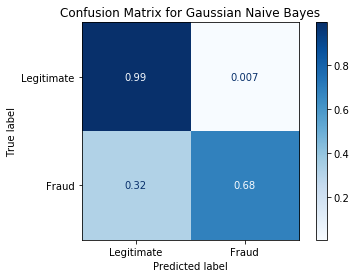

In [8]:
make_SMOTE_model(X_train, y_train, X_test, y_test, GaussianNB(), 'Gaussian Naive Bayes')

# Models

## Logistic Regression

This model did a good job catching frauds: 127 out of 142 (89%). However, it also labeled over 3,800 legitimate transactions as fraudulent. This drove down the model's precision and F1 scores.

Train Accuracy: 	0.9138
Train Precision:	0.018
Train Recall:		0.9456
Train F1:		0.0353


Test Accuracy:		0.9148
Test Precision:		0.0174
Test Recall:		0.9014
Test F1:		0.0341


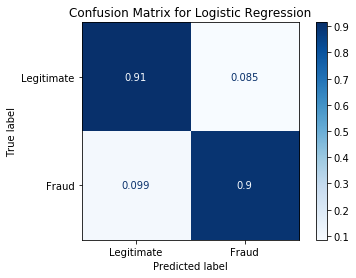

In [11]:
make_SMOTE_model(X_train_sc, y_train_sc, X_test_sc, y_test_sc, LogisticRegression(fit_intercept = False, C = 1e12, class_weight={0: 1, 1: 2}), 'Logistic Regression')

# KNN

Train Accuracy: 	0.9654
Train Precision:	0.0459
Train Recall:		1.0
Train F1:		0.0878


Test Accuracy:		0.9482
Test Precision:		0.0157
Test Recall:		0.4859
Test F1:		0.0303


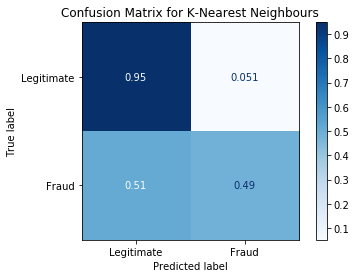

In [12]:
make_SMOTE_model(X_train, y_train, X_test, y_test, KNeighborsClassifier(), 'K-Nearest Neighbours')

Train Accuracy: 	0.9989
Train Precision:	0.5953
Train Recall:		1.0
Train F1:		0.7463


Test Accuracy:		0.9979
Test Precision:		0.4345
Test Recall:		0.8169
Test F1:		0.5672


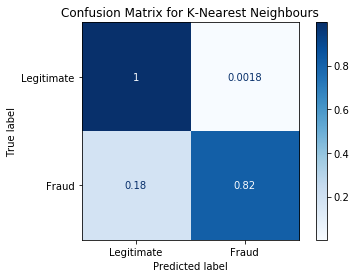

In [13]:
make_SMOTE_model(X_train_sc, y_train_sc, X_test_sc, y_test_sc, KNeighborsClassifier(), 'K-Nearest Neighbours')

In [11]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 331
Before OverSampling, counts of label '0': 198277 

After OverSampling, the shape of train_X: (396554, 30)
After OverSampling, the shape of train_y: (396554,) 

After OverSampling, counts of label '1': 198277
After OverSampling, counts of label '0': 198277


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   14.8s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   49.6s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [18]:
lr1 = LogisticRegression(C=4,penalty='l1', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [ ]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()